<a href="https://colab.research.google.com/github/Viniciusp67/Consultor-de-Direito-Eleitoral/blob/main/LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importando as bibliotecas***

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# ***Escolhendo ação a ser trabalhada***

In [2]:

cripto = "ETH-USD"
inicio = "2016-01-01"
final = "2024-12-31"

dados_cripto = yf.download(cripto, start=inicio, end=final)
print(dados_cripto.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003  320.884003   
2017-11-10  320.670990  324.717987  294.541992  299.252991  299.252991   
2017-11-11  298.585999  319.453003  298.191986  314.681000  314.681000   
2017-11-12  314.690002  319.153015  298.513000  307.907990  307.907990   
2017-11-13  307.024994  328.415009  307.024994  316.716003  316.716003   

                Volume  
Date                    
2017-11-09   893249984  
2017-11-10   885985984  
2017-11-11   842300992  
2017-11-12  1613479936  
2017-11-13  1041889984  


# ***Selecionando campo para trabalhar***

<ipython-input-3-71bdbb36fe1f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_selecionados.rename(columns={'Date': 'Data', 'Close': 'preco_fechamento'}, inplace=True)


        Data  preco_fechamento
0 2017-11-09        320.884003
1 2017-11-10        299.252991
2 2017-11-11        314.681000
3 2017-11-12        307.907990
4 2017-11-13        316.716003


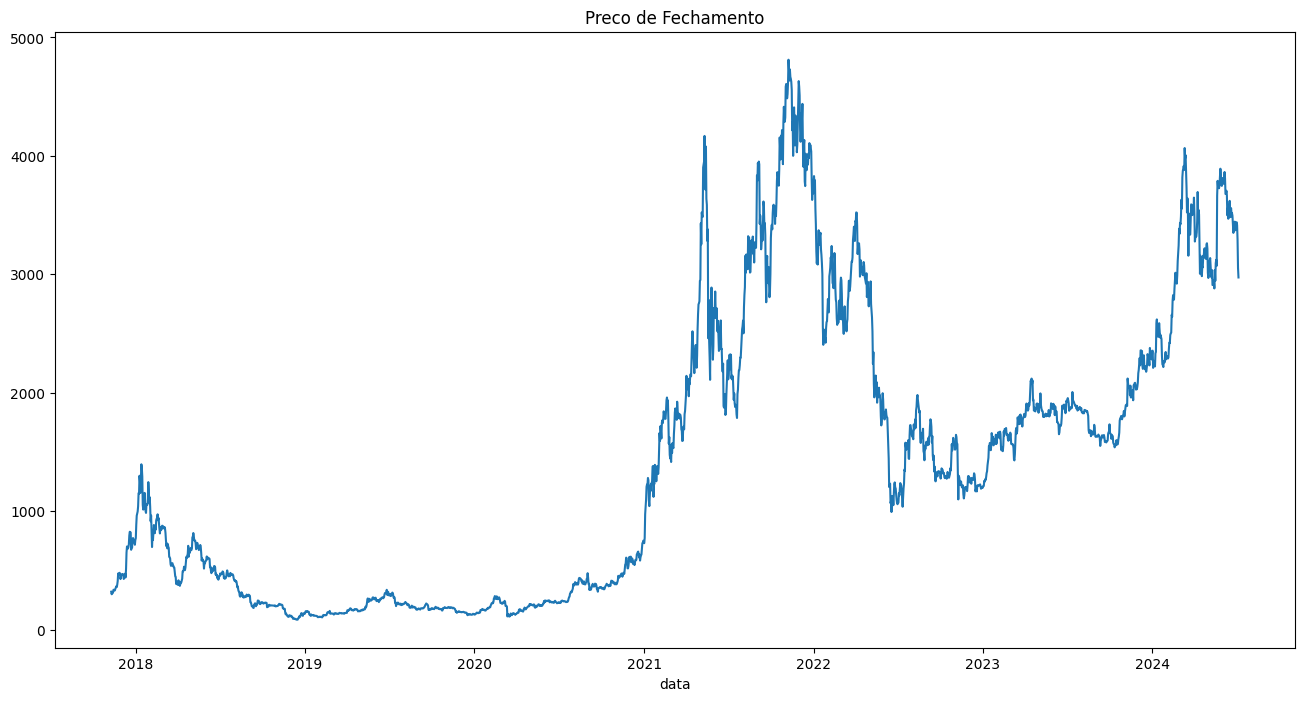

1702 729
(1686, 15)
(1686,)
(713, 15)
(713,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 15, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total param

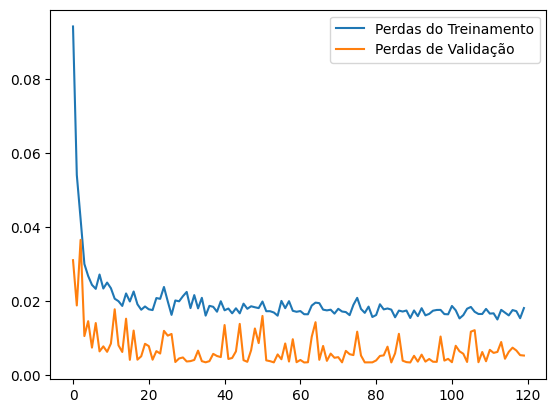

In [3]:

dados_selecionados = dados_cripto[['Close']]
dados_selecionados.reset_index(inplace=True)
dados_selecionados.rename(columns={'Date': 'Data', 'Close': 'preco_fechamento'}, inplace=True)

print(dados_selecionados.head())

df_cripto_fec = dados_selecionados.set_index(pd.DatetimeIndex(dados_selecionados['Data'].values))
df_cripto_fec.drop('Data', axis=1, inplace=True)

plt.figure(figsize=(16,8))
plt.title("Preco de Fechamento")
plt.plot(df_cripto_fec['preco_fechamento'])
plt.xlabel('data')
plt.show()

qtd_linhas = len(df_cripto_fec)
qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cripto_fec)

treino = df_scaled[:qtd_linhas_treino]
teste = df_scaled[qtd_linhas_treino: qtd_linhas_treino + qtd_linhas_teste]

print(len(treino), len(teste))

def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i+steps), 0]
        b = df[i + steps, 0]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

steps = 15
X_train, Y_train = create_df(treino, steps)
X_test, Y_test = create_df(teste, steps)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=120, batch_size=15, verbose=2)
plt.plot(validation.history['loss'], label="Perdas do Treinamento")
plt.plot(validation.history['val_loss'], label="Perdas de Validação")
plt.legend()
plt.show()



# ***Previsões para o conjunto de teste***

In [4]:
predicoes = model.predict(X_test)
predicoes = scaler.inverse_transform(predicoes)



23/23 [==============================] - 2s 17ms/step


# ***Obter os valores reais para o conjunto de teste***

In [5]:
real_values = scaler.inverse_transform(teste[steps:])




# ***Ajustar comprimento das previsões e valores reais se necessário***

In [6]:
if len(real_values) > len(predicoes):
    real_values = real_values[:len(predicoes)]
elif len(real_values) < len(predicoes):
    predicoes = predicoes[:len(real_values)]



# ***Calcular as métricas***

In [7]:
rmse = np.sqrt(mean_squared_error(real_values, predicoes))
mae = mean_absolute_error(real_values, predicoes)
r2 = r2_score(real_values, predicoes)



# ***Imprimir as métricas***


In [8]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")



RMSE: 86.18682377995113
MAE: 64.49707270939253
R²: 0.9862037630318307


# ***Preparar os dados para o gráfico comparativo***

In [9]:

treinamento = df_cripto_fec.iloc[:qtd_linhas_treino]



# ***Calculate lengths of the arrays***

In [10]:
len_preco_fechamento = len(df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:])
len_predicoes = len(predicoes)



# ***Print the lengths for debugging***

In [11]:
print(f"Length of preco_fechamento: {len_preco_fechamento}")
print(f"Length of predicoes: {len_predicoes}")



Length of preco_fechamento: 729
Length of predicoes: 713


# ***Adjust the lengths if necessary and create the DataFrame***

In [12]:
if len_preco_fechamento > len_predicoes:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:][:len_predicoes],
        "predicoes": predicoes.reshape(len_predicoes)
    })
elif len_preco_fechamento < len_predicoes:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:],
        "predicoes": predicoes.reshape(len_preco_fechamento)
    })
else:
    df_teste = pd.DataFrame({
        "preco_fechamento": df_cripto_fec["preco_fechamento"].iloc[qtd_linhas_treino:],
        "predicoes": predicoes.reshape(len_predicoes)
    })



# ***Print the resulting DataFrame for debugging***

In [13]:
print(df_teste)



            preco_fechamento    predicoes
2022-07-08       1222.506226  1586.966919
2022-07-09       1216.978271  1590.918335
2022-07-10       1168.401611  1641.392456
2022-07-11       1097.236572  1491.102905
2022-07-12       1038.191650  1467.587769
...                      ...          ...
2024-06-15       3565.549561  3455.314453
2024-06-16       3620.563477  3502.709961
2024-06-17       3511.378906  3515.214111
2024-06-18       3483.681396  3499.195312
2024-06-19       3559.347412  3389.230469

[713 rows x 2 columns]


# ***Plotando o gráfico comparativo***

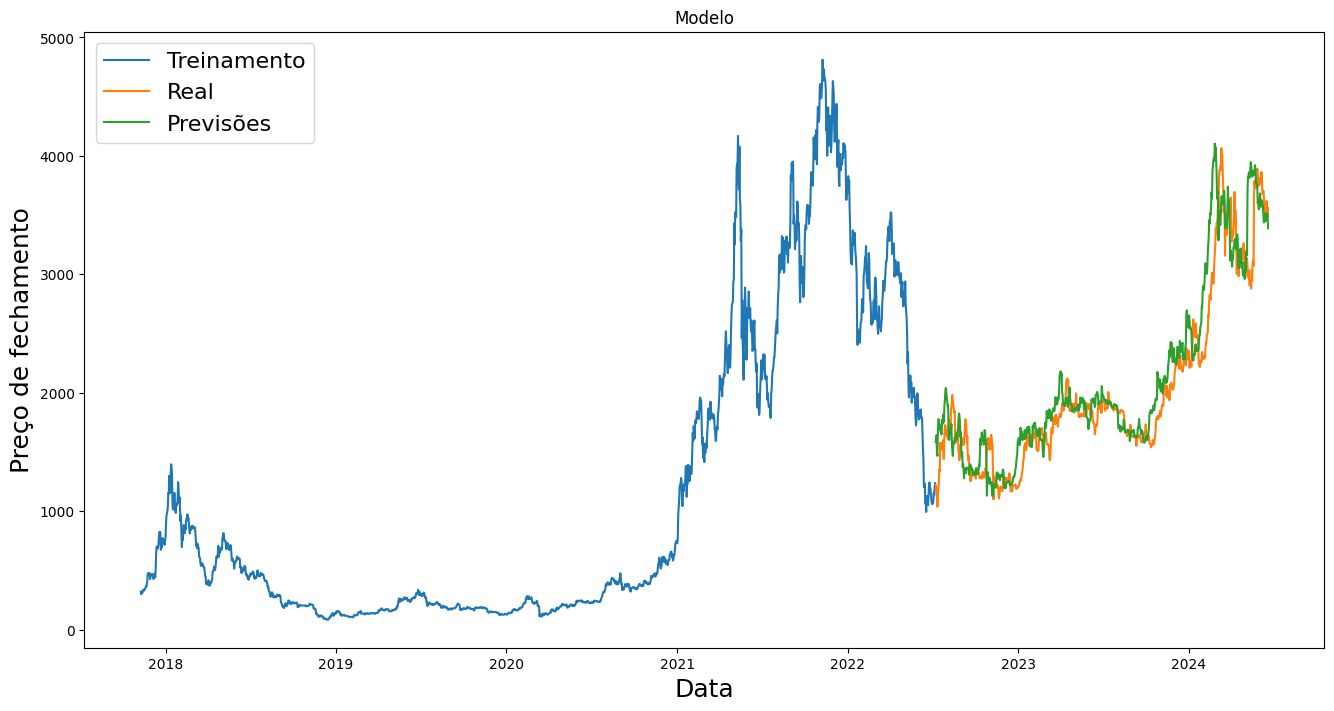

In [14]:
plt.figure(figsize=(16, 8))
plt.title("Modelo")
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço de fechamento', fontsize=18)
plt.plot(treinamento['preco_fechamento'])
plt.plot(df_teste[['preco_fechamento', 'predicoes']])
plt.legend(['Treinamento', 'Real', 'Previsões'], loc=2, prop={'size': 16})
plt.show()
